# m6A Model Comparisons

## Mitchel Cole

## August 24, 2020

# Intro

I created a logistic regression, random forest, and CNN all trained on the
HEK293 data from Linder et al 2015. Now I will compare perfomance across all 3
models in addition to DeepM6A Seq.

In [1]:
import pandas as pd
from scipy import stats
import numpy as np
import Bio
import re

import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Look at training and testing data
bp_window = 201
df = pd.read_csv("../processed_data/20200918_training.csv.gz")
df = df.dropna()

bp_cols = ["bp_{}".format(i) for i in range(201)]
bp_cat = pd.api.types.CategoricalDtype(categories=["A","C","G","T"],
                                      ordered=False)
df[bp_cols] = df[bp_cols].astype(bp_cat) 

# Normalize kmer space from 0-1
p = re.compile('[ACTG]+')
kmer_cols = [x for x in df.columns if p.match(x)]

phylo_cols = [x for x in df.columns if "phylo" in x]

In [2]:
from sklearn.decomposition import PCA

df_train = df[df["sample"] == "hek293"]
def filterSeqs(df1, df2):
    #filter out sequences in df2 that are in df1
    seqs_df1 = df1[bp_cols].agg(''.join, axis=1)
    seqs_df2 = df2[bp_cols].agg(''.join, axis=1)
    return df2[~seqs_df2.isin(seqs_df1)]

df_test_cd8 = df[df["sample"] == "cd8t"]
df_test_cd8 = filterSeqs(df_train, df_test_cd8)

df_test_a549 = df[df["sample"] == "a549"]
df_test_a549 = filterSeqs(df_train, df_test_a549)

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
n_comps_bp = 31
n_comps_phylo = 160
pca_cols_bp = kmer_cols + ['gc_content', 'amino_content', 'purine_content', 's_entropy']
pca_cols_phylo = phylo_cols
bp_categories = [['A','C','G','T'] if i != 100 else ['A'] for i in range(201)]
column_trans = ColumnTransformer(
    [('bp_category', OneHotEncoder(categories=bp_categories, drop='first', dtype='int'), bp_cols),
     ('pca_bp', PCA(n_components=n_comps_bp, random_state=0), pca_cols_bp),
     ('pca_phylo', PCA(n_components=n_comps_phylo, random_state=0), pca_cols_phylo)],
    remainder='drop')

column_trans.fit(df_train)

features = column_trans.transformers_[0][1].get_feature_names().tolist() + \
["pca_bp_{}".format(i) for i in range(n_comps_bp)] + \
["pca_phylo_{}".format(i) for i in range(n_comps_phylo)]

In [4]:
def preprocessOneHot(df):
    # Create input array for one hot encoded sequence models
    # Change encoding from binary to conservation score
    
    # sequence
    df = df.copy(deep=True)
    y = df['group'].values
    df[bp_cols] = df[bp_cols].astype(bp_cat)
    X = column_trans.transform(df)
    
    return X, y

In [5]:
pca_bp = PCA(n_components=n_comps_bp, random_state=0)
pca_bp.fit(df_train[pca_cols_bp])
def preprocessCNN(df_in):
    """For df with n rows, create (5 x 201) x n matrix encoding bp and phyloP.
    Then flattens matrix and appends kmer pca data
    Return matrix (X) and labels (Y)
    """
    df = df_in.copy(deep=True)
    n, _ = df.shape

    df[bp_cols] = df[bp_cols].astype(bp_cat)
    for col in bp_cols:
        df[col] = df[col].cat.codes
        
    X = np.zeros((n, bp_window, 5))
    for i, row in enumerate(df[bp_cols + phylo_cols].itertuples(index=False)):
        for j in range(bp_window):
            bp = int(row[j])
            phylo = row[j + bp_window]
            X[i, j, bp] = 1
            X[i, j, 4] = phylo
    
    y = df['group'].values
    
    return X, y

In [6]:
X_test_cd8_oh, y_test_cd8_oh = preprocessOneHot(df_test_cd8)
X_test_a549_oh, y_test_a549_oh = preprocessOneHot(df_test_a549)

X_test_cd8_cnn, y_test_cd8_cnn = preprocessCNN(df_test_cd8)
X_test_a549_cnn, y_test_a549_cnn = preprocessCNN(df_test_a549)

In [7]:
assert((y_test_cd8_oh == y_test_cd8_cnn).all())
assert(y_test_a549_oh == y_test_a549_cnn).all()

In [8]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import IUPAC

def writeSeqs(df, outfile, sample):
    seqs = df[['bp_{}'.format(i) for i in range(50,151)]].agg(''.join, axis=1)
    seqs = seqs.tolist()
    seqrecords = []
    for i, (status, seq) in enumerate(zip(df["group"].values, seqs)):
        id_name = "Seq_{}_{}_{}".format(i, sample, status)

        record = SeqRecord(
            Seq(seq, IUPAC.ambiguous_dna),
            id = id_name
        )
        seqrecords.append(record)
    SeqIO.write(seqrecords, outfile, "fasta")
writeSeqs(df_test_cd8, "../processed_data/deepm6aseq_input_cd8.fa", "cd8")
writeSeqs(df_test_a549, "../processed_data/deepm6aseq_input_a549.fa", "a549")

In [9]:
def getDeep6Probs(file):
    df = pd.read_table(file, names=["id","prob"], header=None)
    return df["prob"].values

y_deep_m6a_cd8 = getDeep6Probs("../processed_data/deepm6a_cnn_rnn_output_cd8.tsv")
y_deep_m6a_a549 = getDeep6Probs("../processed_data/deepm6a_cnn_rnn_output_a549.tsv")

In [10]:
from joblib import load
import tensorflow as tf
from tensorflow import keras

selector_rf = load('rf_rfecv.joblib')
selector_log = load('log_rfecv.joblib')
cnn = keras.models.load_model('cnn.kt.hb.tf')

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

def plotMetricsAllModels(y, preds, mdl_names, title):
    if len(set(y)) == 2:
        fig, axes = plt.subplots(1, 3, figsize=(18,6))
        xs = np.linspace(0, 1, 100)
        axes[1].plot(xs, xs, linestyle="--", c="grey")
        axes[2].plot(xs, np.flip(xs), linestyle="--", c="grey")
        scores = []
        for y_prob, mdl in zip(preds, mdl_names):
            y_pred = (y_prob > 0.5).astype('int32')
            scores.append(accuracy_score(y, y_pred))
            
            fpr, tpr, _ = roc_curve(y, y_prob)
            roc_auc = auc(fpr, tpr)
            axes[1].plot(fpr, tpr, label='{} AUC = {:.2f}'.format(mdl, roc_auc))

            precision, recall, _ = precision_recall_curve(y, y_prob)
            average_precision = average_precision_score(y, y_prob)
            axes[2].plot(recall, precision, label='{} AP = {:.2f}'.format(mdl, average_precision))
        
        df_scores = pd.DataFrame(data=list(zip(mdl_names, scores)),
                                columns = ['Model','Accuracy'])
        sns.barplot(x = 'Model', y = 'Accuracy', data=df_scores, ax=axes[0],
                   order=mdl_names)
        axes[0].hlines(0.5, -0.5, (len(mdl_names) - 0.5), color='grey')
        axes[0].set_ylim(0,1)
        axes[0].set_title('Classification Accuracy')
        
        axes[1].set_xlabel("False Positive Rate")
        axes[1].set_ylabel("True Positive Rate")
        axes[1].set_title("ROC Curve")
        axes[1].legend(loc="lower right")

        axes[2].set_xlabel("Recall")
        axes[2].set_ylabel("Precision")
        axes[2].set_title("Precision Recall Curve")
        axes[2].legend(loc='lower left')
        fig.tight_layout()
        fig.subplots_adjust(top=0.9)

        fig.suptitle(title)
    
    else:
        fig, axes = plt.subplots(1, 1, figsize=(6,6))
        scores = []
        for y_prob, mdl in zip(preds, mdl_names):
            y_pred = (y_prob > 0.5).astype('int32')
            scores.append(accuracy_score(y, y_pred))
        df_scores = pd.DataFrame(data=list(zip(mdl_names, scores)),
                                columns = ['Model','Accuracy'])
        sns.barplot(x = 'Model', y = 'Accuracy', data=df_scores, ax=axes,
                   order=mdl_names)
        axes.set_title(title)
        axes.set_ylim(0,1)
        axes.hlines(0.5, -0.5, (len(mdl_names) - 0.5), color='grey')
        

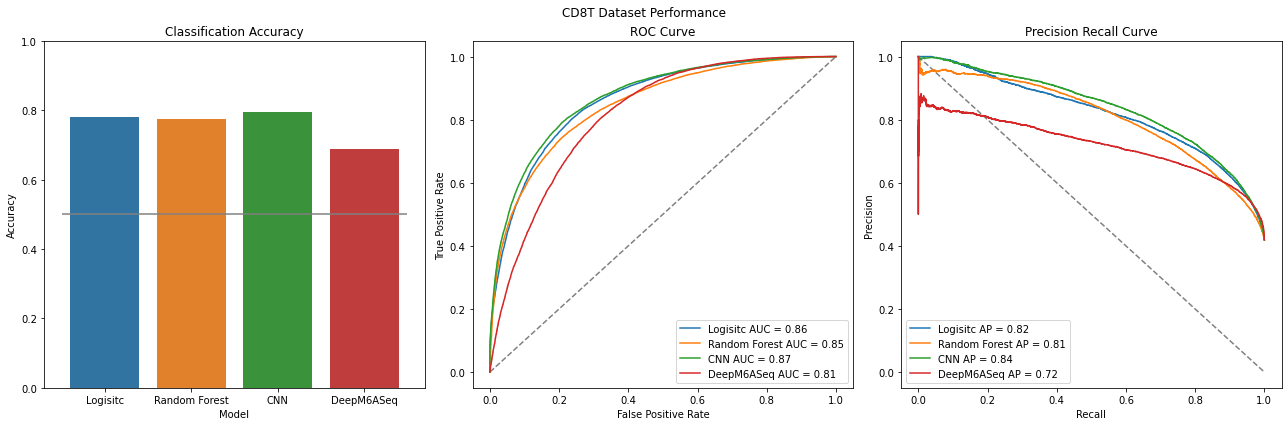

In [12]:
preds_cd8 = [selector_log.predict_proba(X_test_cd8_oh)[:, 1]
            , selector_rf.predict_proba(X_test_cd8_oh)[:, 1]
            , cnn.predict(X_test_cd8_cnn).flatten()
            , y_deep_m6a_cd8]

mdl_names = ["Logisitc", "Random Forest", "CNN", "DeepM6ASeq"]

plotMetricsAllModels(y_test_cd8_cnn, preds_cd8, mdl_names, "CD8T Dataset Performance")

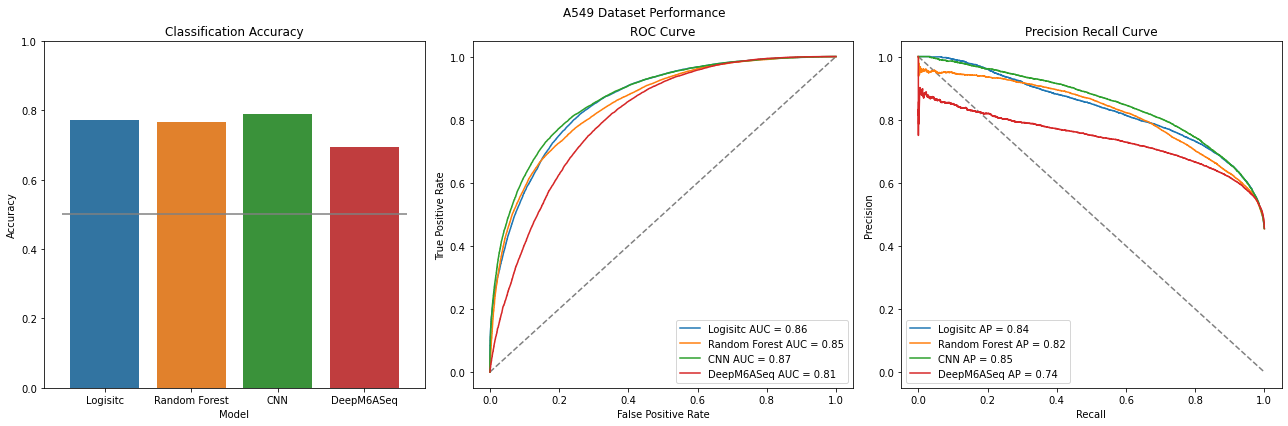

In [13]:
preds_a549 = [selector_log.predict_proba(X_test_a549_oh)[:, 1]
            , selector_rf.predict_proba(X_test_a549_oh)[:, 1]
            , cnn.predict(X_test_a549_cnn).flatten()
            , y_deep_m6a_a549]

plotMetricsAllModels(y_test_a549_cnn, preds_a549, mdl_names, "A549 Dataset Performance")

In [14]:
df_test_hek = pd.read_csv('../processed_data/hek293_dart_test.csv.gz')
df_test_hek = df_test_hek[df_test_hek['bp_100'] == 'A']
df_test_hek['sample'] = 'hek'

X_test_hek_oh, y_test_hek_oh = preprocessOneHot(df_test_hek)
X_test_hek_cnn, y_test_hek_cnn = preprocessCNN(df_test_hek)

writeSeqs(df_test_hek, "../processed_data/deepm6aseq_input_hek_dart.fa", "hek293")

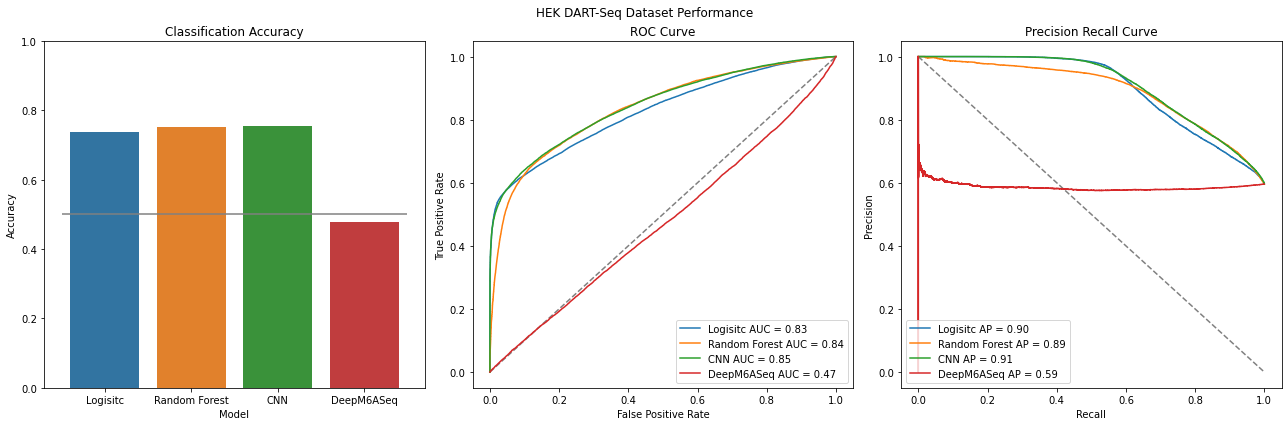

In [15]:
y_deep_m6a_hek = getDeep6Probs("../processed_data/deepm6a_cnn_rnn_output_hek_dart.tsv")

preds_hek = [selector_log.predict_proba(X_test_hek_oh)[:, 1]
            , selector_rf.predict_proba(X_test_hek_oh)[:, 1]
            , cnn.predict(X_test_hek_cnn).flatten()
            , y_deep_m6a_hek]

plotMetricsAllModels(y_test_hek_cnn, preds_hek, mdl_names, "HEK DART-Seq Dataset Performance")

In [16]:
df_test_hek['group'].value_counts()

1    36830
0    24980
Name: group, dtype: int64

In [17]:
df_test_hepg2 = pd.read_csv('../processed_data/hepg2_pos_huang_2019.csv.gz')
df_test_hepg2['sample'] = 'hepg2'

X_test_hepg2_oh, y_test_hegp2_oh = preprocessOneHot(df_test_hepg2)
X_test_hepg2_cnn, y_test_hepg2_cnn = preprocessCNN(df_test_hepg2)

writeSeqs(df_test_hepg2, "../processed_data/deepm6aseq_input_hepg2.fa", "HepG2")

In [18]:
print(filterSeqs(df_train, df_test_hepg2).shape)

(3513, 492)


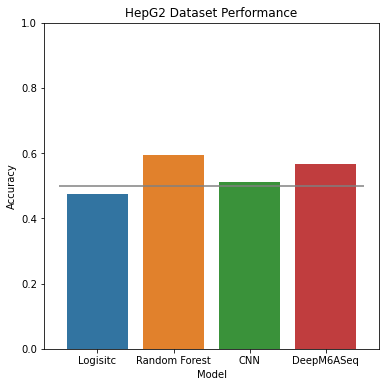

In [19]:
y_deep_m6a_hepg2 = getDeep6Probs("../processed_data/deepm6a_cnn_rnn_output_hepg2.tsv")

preds_hepg2 = [selector_log.predict_proba(X_test_hepg2_oh)[:, 1]
            , selector_rf.predict_proba(X_test_hepg2_oh)[:, 1]
            , cnn.predict(X_test_hepg2_cnn).flatten()
            , y_deep_m6a_hepg2]

plotMetricsAllModels(y_test_hepg2_cnn, preds_hepg2, mdl_names, "HepG2 Dataset Performance")

In [20]:
df_test_molm = pd.read_csv('../processed_data/molm13_vu_2017_input.csv.gz')
df_test_molm['sample'] = 'molm13'

X_test_molm_oh, y_test_molm_oh = preprocessOneHot(df_test_molm)
X_test_molm_cnn, y_test_molm_cnn = preprocessCNN(df_test_molm)

writeSeqs(df_test_molm, "../processed_data/deepm6aseq_input_molm.fa", "MOLM13")

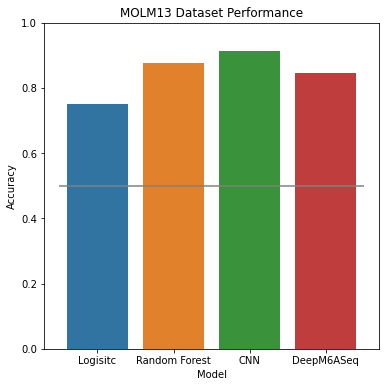

In [21]:
y_deep_m6a_molm = getDeep6Probs("../processed_data/deepm6a_cnn_rnn_output_molm.tsv")

preds_molm = [selector_log.predict_proba(X_test_molm_oh)[:, 1]
            , selector_rf.predict_proba(X_test_molm_oh)[:, 1]
            , cnn.predict(X_test_molm_cnn).flatten()
            , y_deep_m6a_molm]

plotMetricsAllModels(y_test_molm_cnn, preds_molm, mdl_names, "MOLM13 Dataset Performance")

In [22]:
df_test_mm_liver = pd.read_csv('../processed_data/mm9_liver_ke_2015_input.csv.gz')
df_test_mm_liver['sample'] = 'mm_liver'

X_test_mm_liver_oh, y_test_mm_liver_oh = preprocessOneHot(df_test_mm_liver)
X_test_mm_liver_cnn, y_test_mm_liver_cnn = preprocessCNN(df_test_mm_liver)

writeSeqs(df_test_mm_liver, "../processed_data/deepm6aseq_input_liver_mm.fa", "mm9_liver")

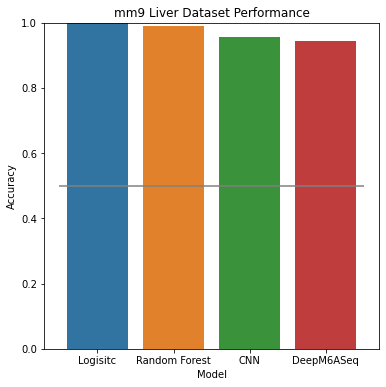

In [23]:
y_deep_m6a_mm_liver = getDeep6Probs("../processed_data/deepm6a_cnn_rnn_output_liver_mm.tsv")

preds_mm_liver = [selector_log.predict_proba(X_test_mm_liver_oh)[:, 1]
            , selector_rf.predict_proba(X_test_mm_liver_oh)[:, 1]
            , cnn.predict(X_test_mm_liver_cnn).flatten()
            , y_deep_m6a_mm_liver]

plotMetricsAllModels(y_test_mm_liver_cnn, preds_mm_liver, mdl_names, "mm9 Liver Dataset Performance")

In [24]:
df_test_mm_brain = pd.read_csv('../processed_data/mm9_brain_ke_2015_input.csv.gz')
df_test_mm_brain['sample'] = 'mm_brain'

X_test_mm_brain_oh, y_test_mm_brain_oh = preprocessOneHot(df_test_mm_brain)
X_test_mm_brain_cnn, y_test_mm_brain_cnn = preprocessCNN(df_test_mm_brain)

writeSeqs(df_test_mm_brain, "../processed_data/deepm6aseq_input_brain_mm.fa", "mm9_brain")

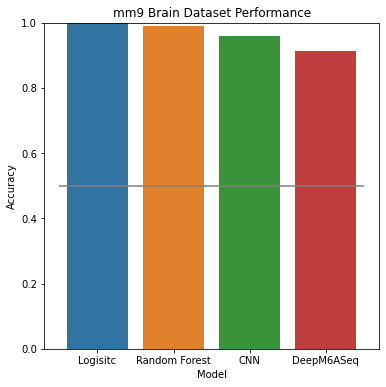

In [25]:
y_deep_m6a_mm_brain = getDeep6Probs("../processed_data/deepm6a_cnn_rnn_output_brain_mm.tsv")

preds_mm_brain = [selector_log.predict_proba(X_test_mm_brain_oh)[:, 1]
            , selector_rf.predict_proba(X_test_mm_brain_oh)[:, 1]
            , cnn.predict(X_test_mm_brain_cnn).flatten()
            , y_deep_m6a_mm_brain]

plotMetricsAllModels(y_test_mm_brain_cnn, preds_mm_brain, mdl_names, "mm9 Brain Dataset Performance")

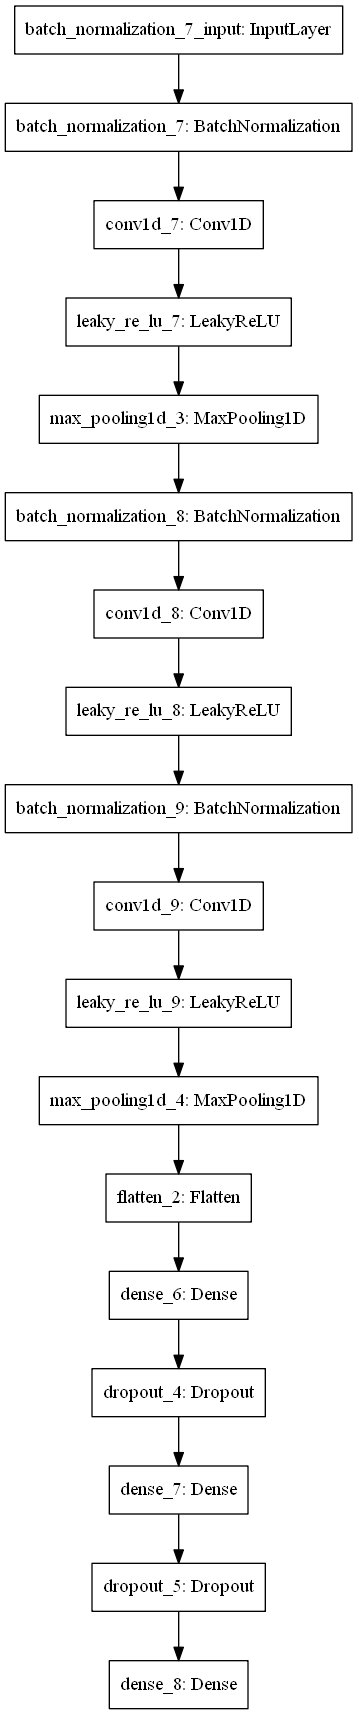

In [26]:
keras.utils.plot_model(cnn, show_shapes=False)